# Extract values to be able to synchronise Miniscope, webcam and ephys.

Webcam not synchronised at the moment because there is no conflict between OE_miniscope and miniscope timestamps. 

Load the required packages (and many more that are not useful)

In [263]:
#%reset

import numpy as np
import csv
from pathlib import Path
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from ipyfilechooser import FileChooser


Import the files

In [264]:
dpath = "//10.69./.1/crnldata/waking/audrey_hay/L1imaging/AnalysedMarch2023/Gaelle/Baseline_recording"
try:
    %store -r dpath
except:
    print("data not in strore")
    dpath ="//10.69./.1/crnldata/waking///L1imaging/AnalysedMarch2023/Gaelle/Baseline_recording"

fc1 = FileChooser(dpath,select_default=True, show_only_dirs = True, title = "<b>Session folder</b>")
display(fc1)

# Sample callback function
def update_my_folder(chooser):
    global dpath
    dpath = chooser.selected
    %store dpath
    return 

# Register callback function
fc1.register_callback(update_my_folder)

FileChooser(path='\\10.69.168.1\crnldata\waking\audrey_hay\L1imaging\AnalysedMarch2023\Gaelle\CGP\ThreeColDots…

In [265]:
folder = Path(dpath)

"""
for file_path in folder.glob('timeStamps.csv'):
    subfolder = file_path.parents[0].stem
    if subfolder == 'V4_Miniscope':
        stamps_miniscope = pd.read_csv(file_path)
    elif subfolder == 'WebCam':
        stamps_webcam = pd.read_csv(file_path)
"""

file_path= f'{folder}/V4_Miniscope/timeStamps.csv'
stamps_miniscope = pd.read_csv(file_path)


# Warning, here I a have moved the OpenEphys file to the video folder. To determine what is the most efficient strategy
for file_path in folder.glob('**/*.npy'):
    subfolder = file_path.parents[0].stem
    if subfolder == 'TTL':
        file = file_path.stem
        print(file_path)
        stamps_OEmini = np.load(file_path)
        datalen = len(stamps_OEmini)
        coords = {
            'recordings' : np.array(['full_words', 'timestamps', 'channel_states', 'channels']),
            'duration_rec' : np.arange(datalen)
        }
        Allstamps = xr.DataArray(coords=coords, dims=['recordings', 'duration_rec'])

for file_path in folder.glob('**/*.npy'):
    subfolder = file_path.parents[0].stem
    if subfolder == 'TTL':
        file = file_path.stem
        stamps_OEmini = np.load(file_path)
        Allstamps.loc[file,:] = stamps_OEmini

folder_Ephys = folder / f'OpenEphys/'
#filenameE = folder_Ephys / f'timestamps.npy'
#stamps_OEOE = np.load(filenameE)


#Allstamps.shape

\\10.69.168.1\crnldata\waking\audrey_hay\L1imaging\AnalysedMarch2023\Gaelle\CGP\ThreeColDotsOK\CGP\sessionB\TTL\channels.npy
\\10.69.168.1\crnldata\waking\audrey_hay\L1imaging\AnalysedMarch2023\Gaelle\CGP\ThreeColDotsOK\CGP\sessionB\TTL\channel_states.npy
\\10.69.168.1\crnldata\waking\audrey_hay\L1imaging\AnalysedMarch2023\Gaelle\CGP\ThreeColDotsOK\CGP\sessionB\TTL\full_words.npy
\\10.69.168.1\crnldata\waking\audrey_hay\L1imaging\AnalysedMarch2023\Gaelle\CGP\ThreeColDotsOK\CGP\sessionB\TTL\timestamps.npy


Plot the different timestamps files. 
Not a necessary step unless there is doubt about the data quality

range(0, 55579)


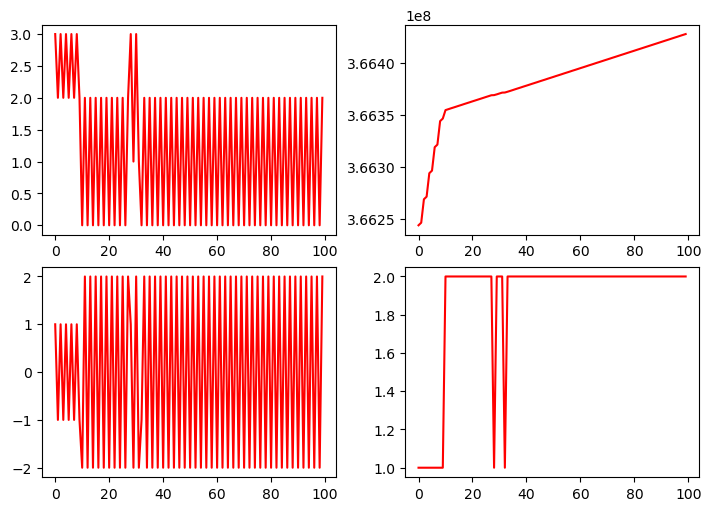

In [266]:
time = range(datalen)
print(time)
fullwords = Allstamps.loc['full_words',:].values
timestamps = Allstamps.loc['timestamps',:].values
channelstates = Allstamps.loc['channel_states',:]
channels = Allstamps.loc['channels',:]

debut = 0
fin = 100
timeTrunc = time[debut:fin]
fullwordsTrunc = fullwords[debut:fin]
timestampsTrunc = timestamps[debut:fin]
channelstatesTrunc = channelstates[debut:fin]
channelsTrunc = channels[debut:fin]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(7,5), layout='constrained') 
ax1.plot(timeTrunc, fullwordsTrunc, 'r')
ax2.plot(timeTrunc, timestampsTrunc, 'r')
ax3.plot(timeTrunc, channelstatesTrunc, 'r')
ax4.plot(timeTrunc, channelsTrunc, 'r')



Compute the delta between each time stamp in the miniscope timestamp file, this allows for determining if and when a frame was dropped.

The calculated frame rate is : 30 Hz


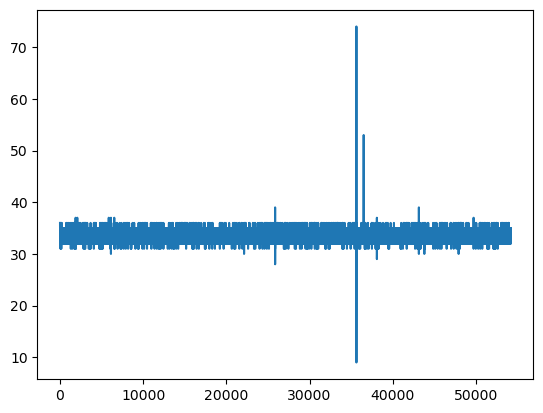

Threshold dropped frame= 50.0
2 frame(s) were dropped : [35625, 36500]


In [267]:
stamps_miniscope_time = stamps_miniscope['Time Stamp (ms)']
delay_stamps = []
number_frames = stamps_miniscope['Time Stamp (ms)'].count()
for i in range(number_frames -1):
    delay_stamps.append(stamps_miniscope_time[i+1] - stamps_miniscope_time[i])

freq_acq = round(1000/(sum(delay_stamps)/len(delay_stamps)))
print("The calculated frame rate is : {} Hz".format(freq_acq) )

delaystampMini = (1000/freq_acq)*1.5
delaystampOE = (25000/freq_acq)*1.5*2

plt.close()
plt.plot(np.diff(stamps_miniscope_time))
plt.show()
print('Threshold dropped frame=',delaystampMini)

delay_stamps = []
dropped_frames = []
number_frames = stamps_miniscope['Time Stamp (ms)'].count()
for i in range(number_frames -1):
    delay_stamps.append(stamps_miniscope_time[i+1] - stamps_miniscope_time[i])
    if delay_stamps[i] > delaystampMini:
        dropped_frames.append(i)

print("{} frame(s) were dropped : {}".format(len(dropped_frames),dropped_frames))

From the xarray that summarises all the timestamps (laser and miniscope) received as TTL by OpenEphys, we extract the timestamps that correspond to either laser or miniscope.

In [268]:
OE_stamps_miniscope = []
OE_stamps_laser = []

for i in range(datalen):
    if channels[i] == 2:
        OE_stamps_miniscope.append(timestamps[i])
    elif channels[i] == 1:
        OE_stamps_laser.append(timestamps[i])

len(OE_stamps_miniscope)

54199

Plot to make sure the right stamps have been rightly distributed to the appropriate list.

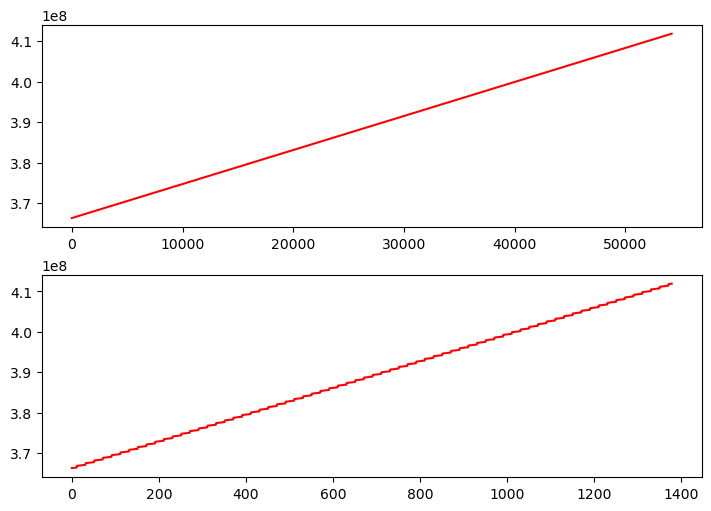

In [269]:
time1 = range(len(OE_stamps_miniscope))
time2 = range(len(OE_stamps_laser))

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(7,5), layout='constrained') 
ax1.plot(time1, OE_stamps_miniscope, 'r')
ax2.plot(time2, OE_stamps_laser, 'r')

Determine if I can see dropped frames in OE

In [270]:
time1 = range(len(OE_stamps_miniscope)-2)
delay_stamps = []
for i in time1:
    delay_stamps.append(OE_stamps_miniscope[i+2] - OE_stamps_miniscope[i])
    if delay_stamps[i] > delaystampOE:
        print(delay_stamps[i], i)

2516.0 36497
2522.0 36498


Normalise time stamps from open ephys signal.
two steps
- remove initial timing by extracting software 0ing from .txt file
- to get time in ms and not in acquisition point (acq rate = 25 kHz)
- for laser, get one value per laser flash

In [271]:
A = []
#for file_path in folderMouse.glob('**/*sync_messages.txt'):
file_path= f'{folder}/sync_messages.txt'
with open(file_path, "r") as f:
    lines = f.readlines()
# Loop through all lines, ignoring header.
# take last element to list (i.e. the process name)
    for l in lines[1:]:
        A.append(l.split()[-1])

# remove acquisition frequency that is normally always 25 kHz
initial_OE_start = int(' '.join([x.split('@')[0] for x in A]))
acqFreqOE = int(' '.join([x[:-2].split('@')[1] for x in A]))

#initial_OE_start = 411044352#stamps_OEOE[0]
# transform in pd series for easier manipulation
B = pd.Series(OE_stamps_miniscope)
C = pd.Series(OE_stamps_laser)

# normalise to ms
OE_stamps_miniscope_n = (B - initial_OE_start)/acqFreqOE
OE_stamps_laser_inter = (C - initial_OE_start)/acqFreqOE

# take only the middle of the laser pulse
OE_stamps_laser_n = [] 
for i in range(len(OE_stamps_laser_n) - 1):
    if (OE_stamps_laser_n[i+1] - OE_stamps_laser_n[i]) < freq_acq:
        interm = OE_stamps_laser_n[i] + 10
        OE_stamps_laser_n.append(interm)



Last, extract important values for the next steps
- start acquisition time for Ca2+ relative to OE internal time and to time zeroed.
- acquisition frequency for Ca2+ imaging
- dropped frame timing

In [272]:
# _n is from 0
acquisition_mini_start_n = OE_stamps_miniscope_n[0]
# _a is from acquisition time software
acquisition_mini_start_a = B[0]
# freq_acq in Hz
freq_acq
# list of dropped frames from miniscope
dropped_frames

outSumm = pd.Series([acquisition_mini_start_n, acquisition_mini_start_a, freq_acq, dropped_frames],
              index=['Miniscope start from 0', 'Miniscope start from Acq time soft', 'mini acq freq', 'dropped frames'])

outSumm

        

Miniscope start from 0                       5.16988
Miniscope start from Acq time soft       366354399.0
mini acq freq                                     30
dropped frames                        [35625, 36500]
dtype: object

In [273]:
filenameOut = folder / f'SynchroFileCorrect.xlsx'
writer = pd.ExcelWriter(filenameOut)
outSumm.to_excel(writer)
writer.close()
